# Motion Estimation
Using the processed images produced by the fourth notebook, we're going to apply Optical Flow algorithms from the OpenCV library to estimate the motion of the algae.

## Importing necessary libraries and notebooks

In [1]:
import xarray as xr
import io
import os
import cv2
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from matplotlib import ticker
from IPython.display import Image, display
from PIL import Image as PILImage

# Import the other notebooks without running their cells
from ii_Data_Manipulation import visualize_4
from iii_GOES_average import time_list, visualize_aggregate, calculate_median
from iv_Image_Processing import collect_times, crop_image, save_aggregate, binarize_image, bilateral_image, process_dates, process_directory
from v_i_OF_Functions import plot_of, plot_of_vectors, overlay_of_vectors, create_of_gif, plot_vector_field, display_image_cv

ImportError: cannot import name 'a3sba' from 'iv_Image_Processing' (/home/yahia/Documents/Jupyter/Sargassum/iv_Image_Processing.py)

## Optical Flow Algorithms

### 1. Farnebäck's method

In [4]:
def farneback_flow(prev_img, next_img):
    """
    Returns:
    - flow : np.ndarray
        The computed flow image that will have the same size as `prev_img` and
        type CV_32FC2. Each element of the flow matrix will be a vector that
        indicates the displacement (in pixels) of the corresponding pixel from
        the first image to the second image.

    Method Parameters:
    - flow : np.ndarray
        Optional input flow estimate. It must be a single precision floating point
        image with the same size as `prev_img`. If provided, the function uses it as
        an initial approximation of the flow. If None, the function estimates the flow
        from scratch.
    - pyr_scale : float
        The image scale (<1) to build pyramids for each image; pyr_scale=0.5
        means a classical pyramid, where each next layer is twice smaller than
        the previous one.
    - levels : int
        The number of pyramid layers including the initial image. Levels=1
        means that no extra layers are created and only the original images are used.
    - winsize : int
        The size of the window used to smooth derivatives used as a basis
        for the polynomial expansion. The larger the size, the smoother the
        input image and the more robust the algorithm is to noise, but the more
        blurred motion details become.
    - iterations : int
        The number of iterations the algorithm will perform at each pyramid level.
        More iterations can improve the accuracy of the flow estimation.
    - poly_n : int
        The size of the pixel neighborhood used to find polynomial expansion
        in each pixel. Typical values are 5 or 7.
    - poly_sigma : float
        The standard deviation of the Gaussian that is used to smooth derivatives
        used as a basis for the polynomial expansion. This parameter can
        typically be ~1.1 for poly_n=5 and ~1.5 for poly_n=7.
    - flags : int
        Operation flags that can specify extra options such as using the initial
        flow estimates or applying a more sophisticated form of smoothing:
        - cv2.OPTFLOW_USE_INITIAL_FLOW: Uses the input flow as an initial flow estimate.
        - cv2.OPTFLOW_FARNEBACK_GAUSSIAN: Uses a Gaussian window for smoothing
          derivatives instead of a box filter.
    """
    # Make images grayscale
    prev_img = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    next_img = cv2.cvtColor(next_img, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_img, next_img, flow = None, pyr_scale=0.5, levels=3, winsize=15, 
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    return flow


### Visualizing the Flow

In [5]:
def plot_optical_flow(flow):
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    plt.figure(figsize=(10, 10))
    plt.imshow(mag, cmap='hot')
    plt.colorbar()
    plt.title('Optical Flow Magnitude')
    plt.show()

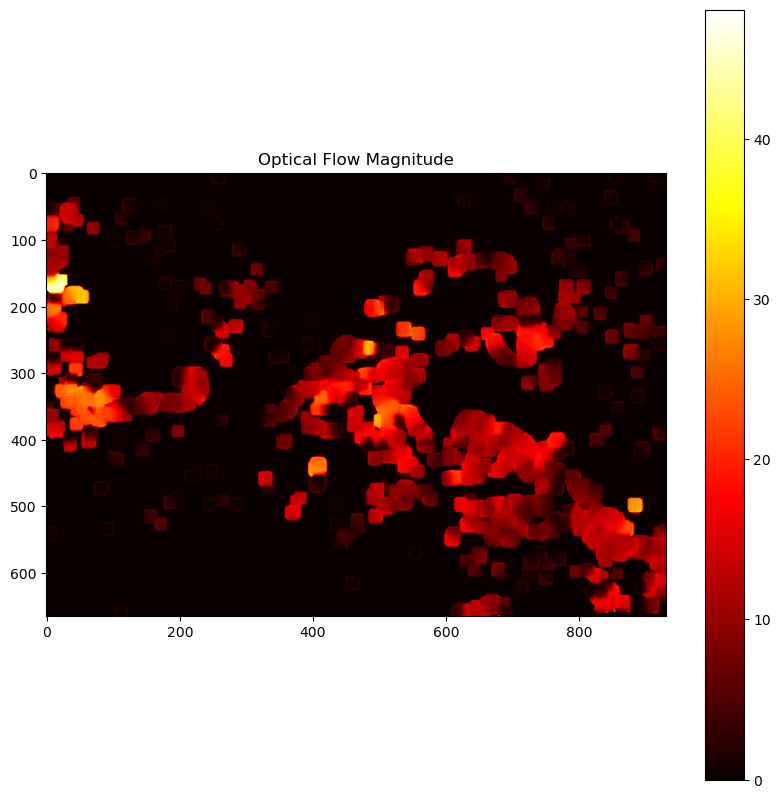

In [6]:
if __name__ == '__main__':
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    flow = farneback_flow(prev_img, next_img)
    plot_optical_flow(flow)

We can also visualize the motion field through vectors.

In [5]:
def plot_optical_flow_vectors(flow, base_img, step=16, scale=1):
    """
    Plots the optical flow vectors over the base image.
    
    :param flow: Computed flow vectors with shape (H, W, 2).
    :param base_img: Base image on which to plot the vectors.
    :param step: Grid step size for sampling vectors. Smaller values increase density.
    :param scale: Scaling factor for the magnitude of vectors to enhance visibility.
    """
    H, W = flow.shape[:2]
    y, x = np.mgrid[0:H:step, 0:W:step].reshape(2, -1).astype(int)
    fx, fy = flow[y, x].T

    plt.figure(figsize=(10, 10))
    plt.imshow(base_img)  # Convert grayscale to RGB
    plt.quiver(x, y, fx, fy, color='r', angles='xy', scale_units='xy', scale=scale, width=0.005)
    plt.xlim([0, W])
    plt.ylim([H, 0])
    plt.title('Optical Flow Vectors')
    plt.show()

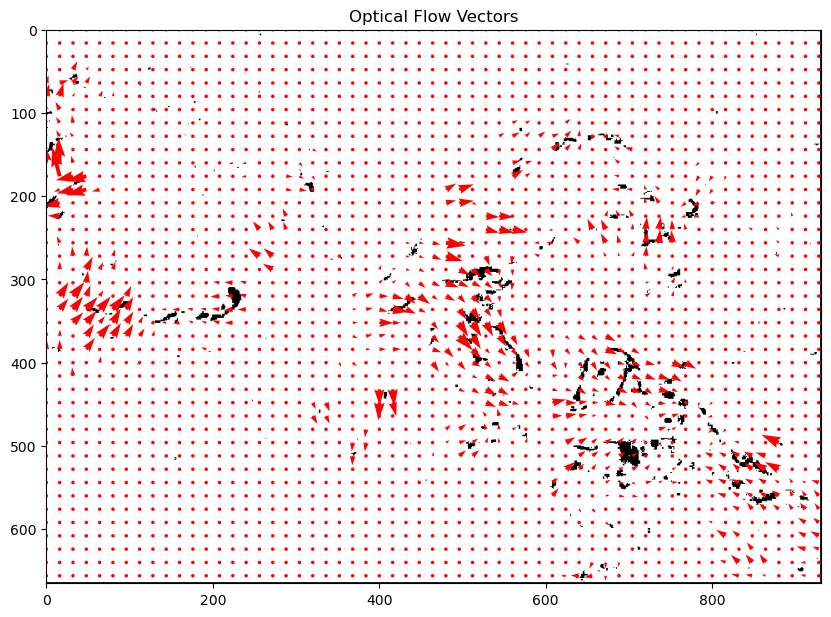

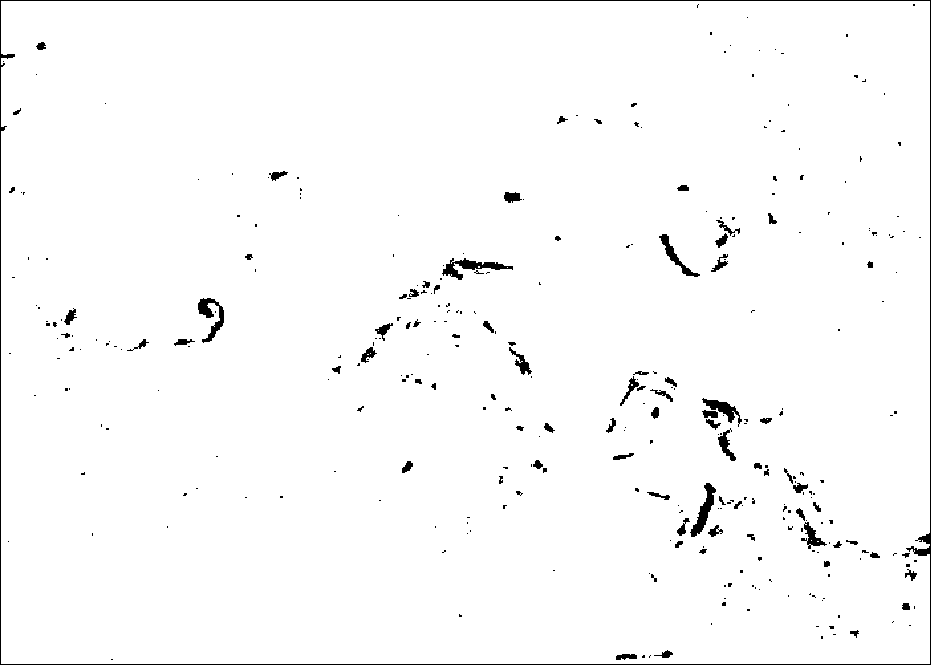

In [6]:
if __name__ == '__main__':
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    flow = farneback_flow(prev_img, next_img)
    plot_optical_flow_vectors(flow, prev_img, step=16, scale=1.25)
    display(Image(filename="/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png", width =750))

In [21]:
def overlay_optical_flow_vectors(flow, base_img, step=16, scale=1, color=(255, 0, 0)):
    """
    Overlays optical flow vectors on an image and returns the resulting image with vectors.
    """
    # Ensure base_img is in RGB to display colored vectors
    if len(base_img.shape) == 2:
        base_img = cv2.cvtColor(base_img, cv2.COLOR_GRAY2RGB)
    
    H, W = flow.shape[:2]
    y, x = np.mgrid[0:H:step, 0:W:step].reshape(2, -1).astype(int)
    fx, fy = flow[y, x].T

    # Create a figure for drawing
    result_img = np.copy(base_img)
    for i in range(len(x)):
        start_point = (x[i], y[i])
        end_point = (int(x[i] + fx[i] * scale), int(y[i] + fy[i] * scale))
        cv2.arrowedLine(result_img, start_point, end_point, color, 1, tipLength=0.3)

    return result_img

### GIF
We can try to visualize the result using a GIF.

In [8]:
def create_optical_flow_gif(images, gif_path, fps=1, loop=10):
    """
    This function already calculates the flow, so no need to do that outside the function
    """
    images_for_gif = []
    
    for i in range(len(images) - 1):
        prev_img = images[i]
        next_img = images[i+1]
        flow = farneback_flow(prev_img, next_img)
        overlay_img = overlay_optical_flow_vectors(flow, prev_img)
        
        images_for_gif.append(prev_img)  # Add original image
        images_for_gif.append(overlay_img)  # Add image with vectors

    # Add the last image to the gif
    images_for_gif.append(images[-1])

    # Write GIF
    imageio.mimsave(gif_path, images_for_gif, fps=fps, loop=loop)

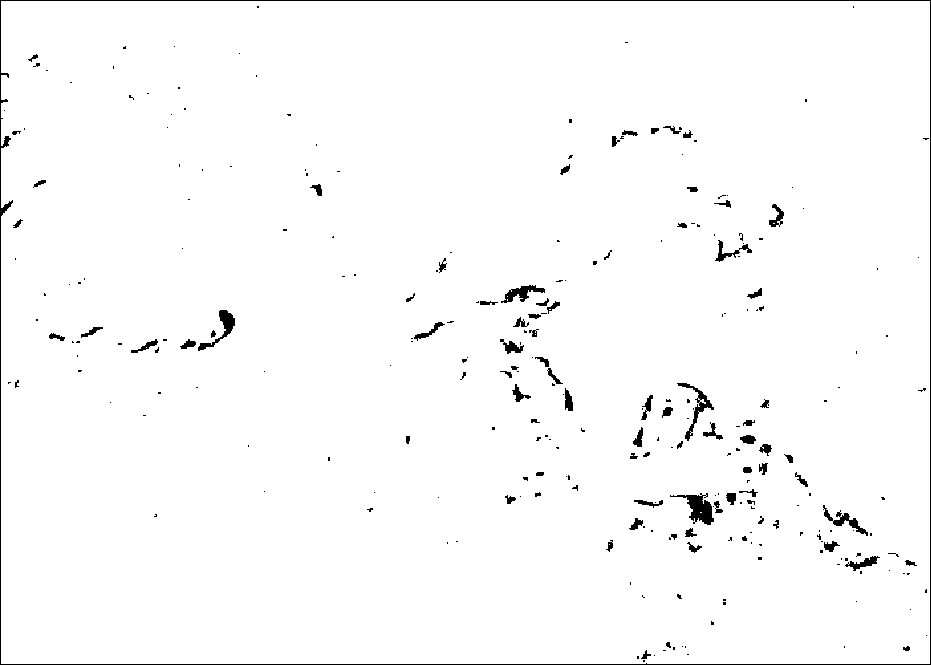

In [9]:
if __name__ == '__main__':
    # Saving the GIF
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    images = [prev_img, next_img]
    create_optical_flow_gif(images, '/home/yahia/Documents/Jupyter/Sargassum/Images/GIFs/optical_flow.gif', fps=0.2, loop=10)
    
    # Displaying the GIF
    gif_path = '/home/yahia/Documents/Jupyter/Sargassum/Images/GIFs/optical_flow.gif' 
    display(Image(filename=gif_path))

This algorithm doesn't track the images very well, maybe trying with a viridis color map would produce better results.

### Trying different Colormaps

The binarized image doesn't seem to be adapted for our algorithm, so we'll try to apply our algorithm on Viridis images.

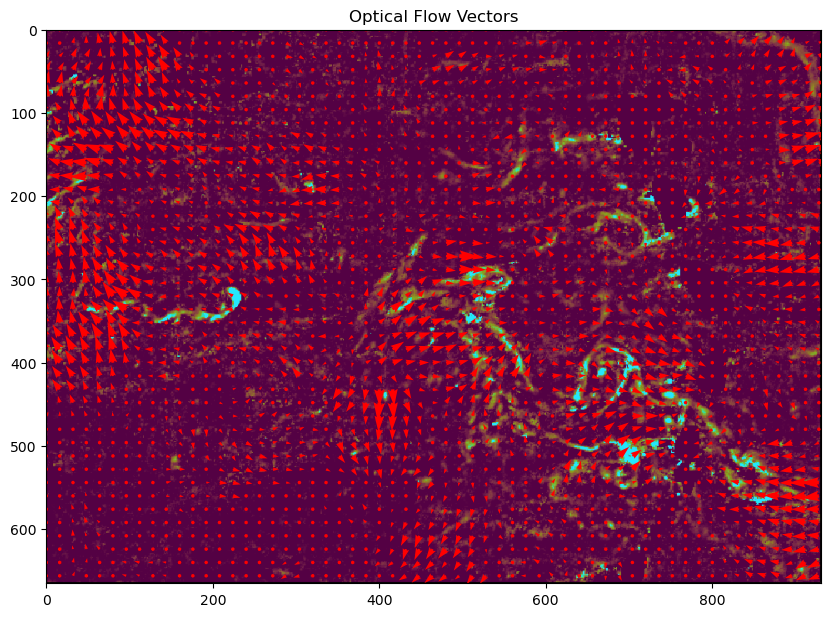

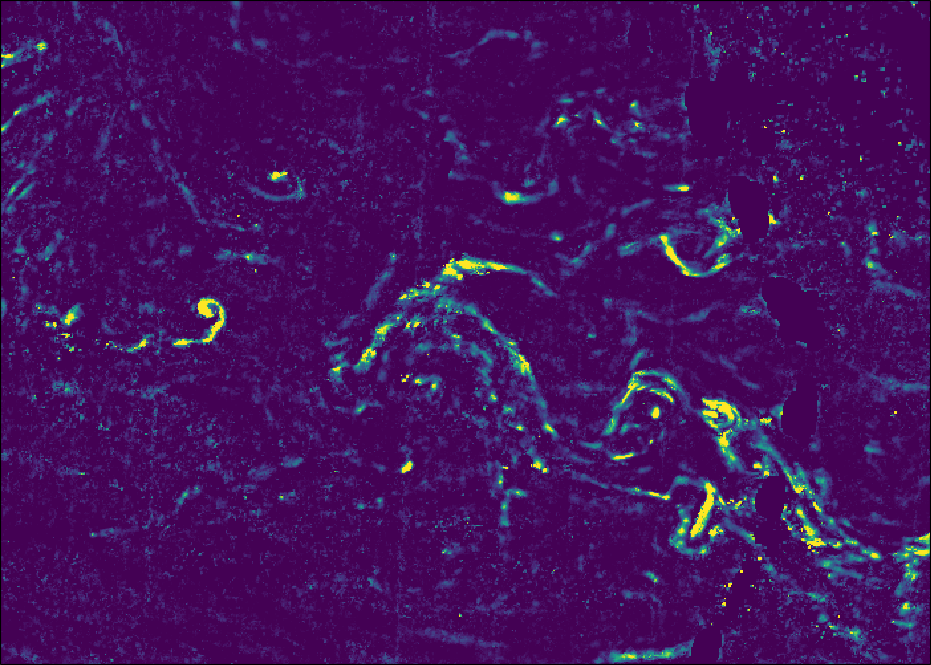

In [10]:
if __name__ == '__main__':
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    flow = farneback_flow(prev_img, next_img)
    plot_optical_flow_vectors(flow, prev_img, step=16, scale=1.25)
    display(Image(filename="/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png", width =750))

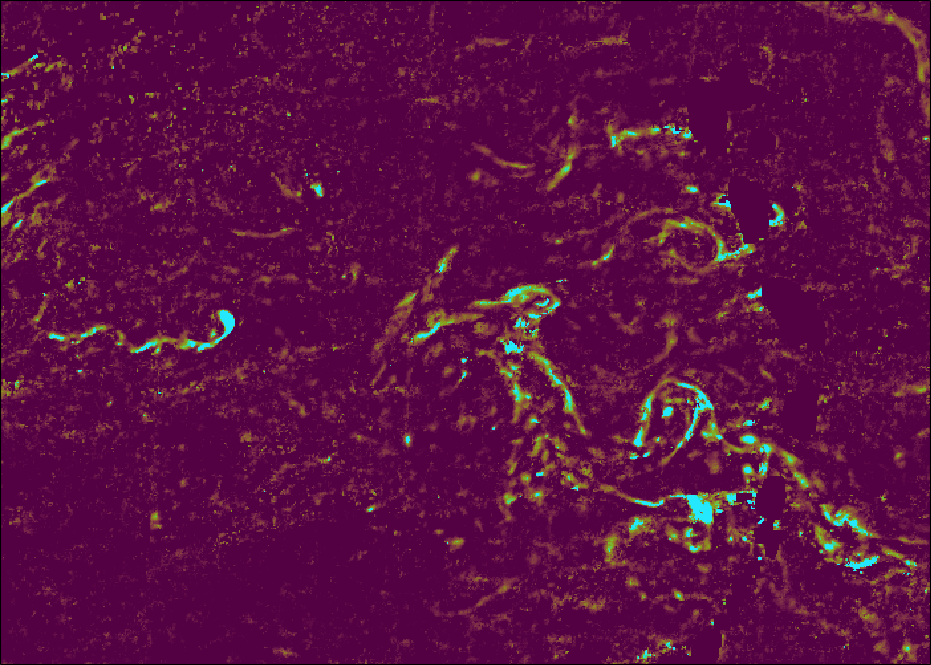

In [11]:
if __name__ == '__main__':
    # Saving the GIF
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    images = [prev_img, next_img]
    create_optical_flow_gif(images, '/home/yahia/Documents/Jupyter/Sargassum/Images/GIFs/optical_flow.gif', fps=0.4, loop=10)
    
    # Displaying the GIF
    gif_path = '/home/yahia/Documents/Jupyter/Sargassum/Images/GIFs/optical_flow.gif' 
    display(Image(filename=gif_path))

### 2. Lucas-Kanade

In [12]:
def LK_flow(prev_img, next_img):
    """
    Returns:
        new_points (np.ndarray): The points in the second image.
        status (np.ndarray): Array of statuses for each point.
        err (np.ndarray): Error for each point.
    """
    # Ensure images are grayscale
    if len(prev_img.shape) == 3:
        prev_img = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    if len(next_img.shape) == 3:
        next_img = cv2.cvtColor(next_img, cv2.COLOR_BGR2GRAY)
    
    # Parameters for ShiTomasi corner detection
    feature_params = {'maxCorners': 100,
                      'qualityLevel': 0.3,
                      'minDistance': 7,
                      'blockSize': 7}

    # Parameters for Lucas-Kanade optical flow
    lk_params = {'winSize': (15, 15),
                 'maxLevel': 2,
                 'criteria': (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)}

    # Find good features to track (Shi-Tomasi corner detector)
    p0 = cv2.goodFeaturesToTrack(prev_img, mask=None, **feature_params)
    
    # Calculate optical flow (Lucas-Kanade)
    if p0 is not None:
        p1, st, err = cv2.calcOpticalFlowPyrLK(prev_img, next_img, p0, None, **lk_params)
        return p0, p1, st, err
    else:
        return None, None, None, None

A function to plot a vector field using two sets of points (that represenet the ends of the vector).

In [13]:
def plot_vector_field(p0, p1, status):
    plt.figure(figsize=(10, 10))
    for i, (new, old) in enumerate(zip(p1, p0)):
        a, b = new.ravel()
        c, d = old.ravel()
        if status[i]:
            plt.arrow(c, d, (a - c), (b - d), color='red', head_width=2, head_length=3, linewidth=1.5, length_includes_head=True)

    plt.axis('off')
    plt.imshow(prev_img, cmap='gray')
    plt.show()

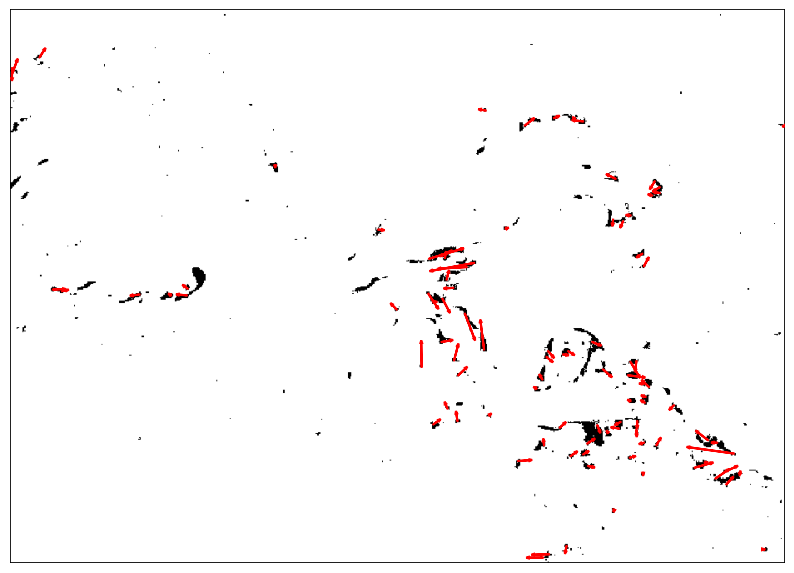

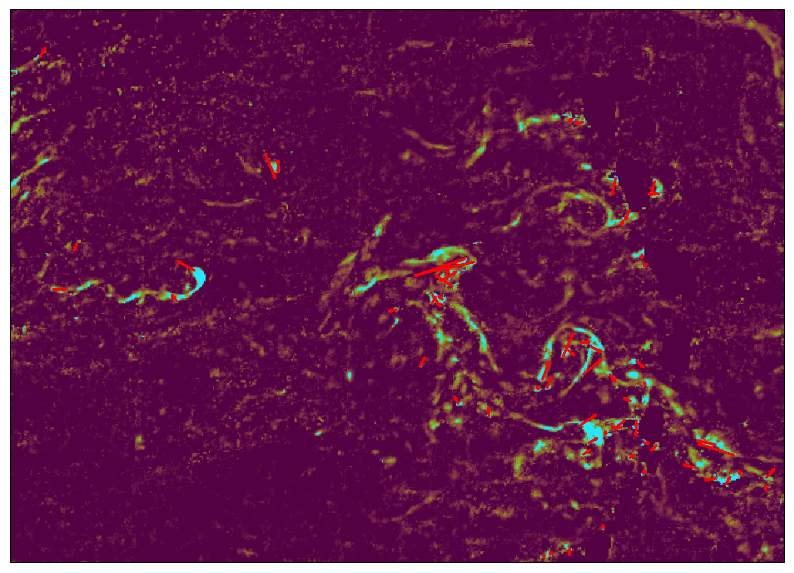

In [14]:
if __name__ == '__main__':
    # Binarized
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    p0, p1, st, err = LK_flow(prev_img, next_img)
    if p0 is not None and p1 is not None:
        # Filter out only points with successful tracking
        good_new = p1[st==1]
        good_old = p0[st==1]
    
        plot_vector_field(good_old, good_new, st[st==1])
    # Viridis
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    p0, p1, st, err = LK_flow(prev_img, next_img)
    if p0 is not None and p1 is not None:
        # Filter out only points with successful tracking
        good_new = p1[st==1]
        good_old = p0[st==1]
    
        plot_vector_field(good_old, good_new, st[st==1])

This function doesn't plot the image directly but returns it instead.

In [15]:
def LK_vector_field(p0, p1, status, prev_img):
    """
    Creates an image with vectors plotted over the input image.
    
    Args:
    - p0: Initial points in the first image.
    - p1: Corresponding points in the second image.
    - status: Status array from optical flow indicating which points are valid.
    - prev_img: The first image on which vectors are drawn.
    
    Returns:
    - An image array with vectors drawn.
    """
    # Create a figure to draw the vectors
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(prev_img, cmap='gray')
    for i, (new, old) in enumerate(zip(p1, p0)):
        #if status[i]:
        a, b = new.ravel()
        c, d = old.ravel()
        ax.arrow(c, d, (a - c), (b - d), color='red', head_width=2, head_length=3, linewidth=1.5, length_includes_head=True)
    
    ax.axis('off')
    
    # Save the plot to a buffer instead of showing it
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    
    # Load the image from the buffer
    img_array = np.array(PILImage.open(buf))
    
    return img_array

### OpenCV Image Display

In [16]:
def display_image_cv(image_array):
    # OpenCV might load images in BGR format, ensure to convert to RGB if necessary
    if image_array.shape[2] == 3:  # Color image
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    cv2.imshow('Optical Flow Vectors', image_array)
    while True:
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

In [17]:
if __name__ == '__main__':
    # Binary image
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    p0, p1, st, err = LK_flow(prev_img, next_img)
    img_with_vectors = LK_vector_field(p0, p1, st, prev_img)
    display_image_cv(img_with_vectors)

### Image Superposition
This is a function that takes two images (preferably binarized for clarity) and superposes them on top of each other with different colors.

In [18]:
def superpose_images(image1, image2, color1=(255, 0, 0), color2=(0, 255, 0)):
    """
    Superposes the black regions of two binarized images onto a white background with different colors.
    Black areas from image1 and image2 are shown in distinct colors, and the background remains white.

    Parameters:
    - image1 (numpy.ndarray): The first binarized image, white background with black algae.
    - image2 (numpy.ndarray): The second binarized image, white background with black algae.
    - color1 (tuple): RGB color for the algae in the first image.
    - color2 (tuple): RGB color for the algae in the second image.

    Returns:
    - numpy.ndarray: An image with the black regions of the two input images superposed in the specified colors.
    """
    # Ensure images are grayscale
    if len(image1.shape) == 3:
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    if len(image2.shape) == 3:
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Threshold images to ensure they are binary
    _, image1 = cv2.threshold(image1, 127, 255, cv2.THRESH_BINARY)
    _, image2 = cv2.threshold(image2, 127, 255, cv2.THRESH_BINARY)

    # Create a white RGB image with the same dimensions as the input images
    height, width = image1.shape
    colored_image = np.full((height, width, 3), fill_value=(255, 255, 255), dtype=np.uint8)  # White background

    # Apply the specified colors to the black regions of each binary image
    colored_image[(image1 == 0)] = color1  # Apply color1 where image1 is black
    colored_image[(image2 == 0)] = color2  # Apply color2 where image2 is black

    return colored_image

In [19]:
if __name__ == '__main__':
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    superposed = superpose_images(prev_img, next_img)
    display_image_cv(superposed)

In [ ]:
if __name__ == '__main__':
    motion_field = overlay_optical_flow_vectors(flow, superposed, step=16, scale=1, color=(0,0,255))
    display_image_cv(motion_field)